# Weather Forecasting

We look at the problem of forecasting temperature given 14 different quantities (e.g. temperature, pressure, wind direction, humidity).

**Goal:** given data as far back as `lookback` timesteps (observations are separated by 10 minutes) and sampled every `steps` observations, can we predict the temperature in `delay` timestemps?

```
lookback = 720  # i.e. go back 5 days
steps = 6  # we use observations every hour
delay = 144 # we wish to predict the temperature in 24 hours time
```

# 1. Data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
data_dir = '/home/d869321/Data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


The data is 420,551 lines long. Let's convert into into a numpy array.

In [3]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]  # we leave out the timestamps
    float_data[i, :] = values

Let us plot the temperatures.

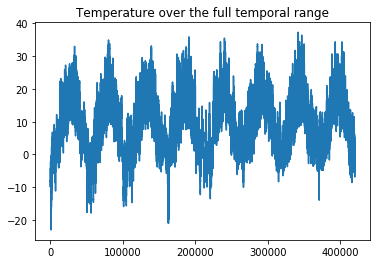

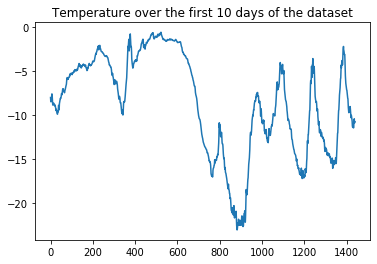

In [4]:
temp = float_data[:, 1]  # temperature (in Celsius)
plt.title('Temperature over the full temporal range')
plt.plot(range(len(temp)), temp)

plt.figure()
plt.title('Temperature over the first 10 days of the dataset')
plt.plot(range(1440), temp[:1440])

Measurements are recorded every 10 minutes so we have 144 observations per day.

## 1.1. Preparing the Data
We need to normalize each timeseries separately so they take values on a similar scale. We shall only use the first 200,000 timesteps as training data so the mean and standard deviation shall be computed just on this data to avoid data leakage.

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

We also need to write a generator that yields a batch of data along with a target temperature. As sample $N$ and sample $N + 1$ overlap greatly, we generate the samples on the fly using the original data. The generator will yield a tuple `(samples, targets)`.

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """
    data: dataset we generate the sample and future value from
    lookback: how far back should the sampled data go
    delay: how many timesteps in the future should the target be
    min_index, max_index: delimit which timesteps can we draw from
    step: sample every step-th datapoint
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1  # final observation must lie at least delay timesteps before pred
        
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:  # case where there is less than batch_size available samples 
                i = min_index + lookback  # revert back to starting sample block when we reach end
            rows = np.arange(i, min(i + batch_size, max_index))  # batch focuses on endpoint index
            i += len(rows)  # starting index for next batch
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)  # sample definition
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

The training generator looks at the first 200,000 time steps, the validation generator looks at the following 100,000 and the test generator will look at the remainder.

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, 
                      shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, 
                    step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, 
                     step=step, batch_size=batch_size)

# num steps to draw from val_gen to see entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size
# num steps to draw from test_gen to see entire test set
test_steps = len(float_data) - 300001 - lookback

# 2. Baseline Prediction
A common-sense approach is predict the temperature 24 hours from now is equal to the temperature right now. We shall evaluate the prediction models using MAE.

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]  # 3rd index corresds to temperature column, 2nd index takes last observation
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()
        

0.2897359729905486


We need to convert the MAE of 0.29 back into Celsius by inverting the normalization.

In [9]:
celsius_mae = 0.28969941979609765 * std[1]
print(celsius_mae)

2.5645638478601653


The baseline has an MAE of 2.57 Celsius.

We can see whether we can do better with a straightforward neural network.

# 3. Basic Neural Network
We can now implement a feed-forward network with two layers.

In [10]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


We can then fit the model.

In [11]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 1.5865 - val_loss: 0.5306
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.5505 - val_loss: 0.3887
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3030 - val_loss: 0.2514
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2688 - val_loss: 0.3100
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2563 - val_loss: 0.2857
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2481 - val_loss: 0.2683
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2392 - val_loss: 0.2073
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2335 - val_loss: 0.3438
Epoch 9/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2287 - val_loss: 0.3398
Epoch 10/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2234 - val_lo

We can then evaluate the model.

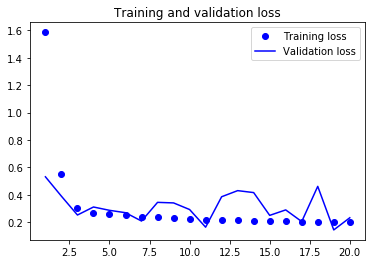

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model does slightly better than the baseline. Let us try applying RNNs to forecast temperature.

# 3. RNNs

The first approach first flattened the timeseries, which removed the notion of time from the input data. We shall now use Gated recurrent units (GRUs). They follow the same principle as LSTM, but they are somewhat streamlined and hence cheaper to run (but not as reprsentative as LSTMs).

In [13]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


We can then fit the above model.

In [14]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 56s 112ms/step - loss: 0.3069 - val_loss: 0.3165
Epoch 2/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2850 - val_loss: 0.3104
Epoch 3/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2784 - val_loss: 0.3159
Epoch 4/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2711 - val_loss: 0.3362
Epoch 5/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2669 - val_loss: 0.3475
Epoch 6/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2613 - val_loss: 0.3400
Epoch 7/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2586 - val_loss: 0.3417
Epoch 8/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2545 - val_loss: 0.3556
Epoch 9/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2518 - val_loss: 0.3736
Epoch 10/20
500/500 [==============================] - 55s 110ms/step - l

We can then evaluate the model.

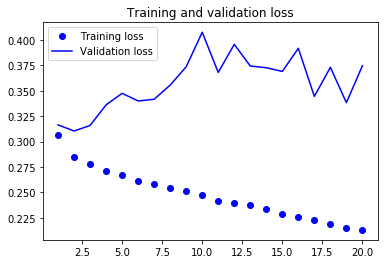

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model reached ~0.31 MAE, which in Celsius corresponds to:

In [16]:
print('MAE: %s Celsius' %(0.31 * std[1]))

MAE: 2.744274715483432 Celsius


## 3.1. Using Recurrent Dropout to avoid overfitting
Here, the dropout mask should be applied at every time unit (instead of varying randomly over the timesteps). In addition, in order to regularize the representations formed by the recurrent gates (i.e. LSTM or GRU), a temporally constan dropout mask should be applied to the inner recurrent activations of the layer. We thus need to specify both `dropout` (the dropout rate for input units of the layer) and `recurrent_dropout` (the dropout rate of the recurrent units).

In [17]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.15, recurrent_dropout=0.15, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


We can now fit the model using the dropout regularization.

In [18]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 57s 115ms/step - loss: 200734287736.8276 - val_loss: 0.3574
Epoch 2/40
500/500 [==============================] - 57s 114ms/step - loss: 11681021534.9957 - val_loss: 0.3088
Epoch 3/40
500/500 [==============================] - 57s 114ms/step - loss: 1498294769.6951 - val_loss: 0.3298
Epoch 4/40
500/500 [==============================] - 57s 114ms/step - loss: 395586962.6539 - val_loss: 0.3266
Epoch 5/40
500/500 [==============================] - 57s 114ms/step - loss: 504895696.4261 - val_loss: 0.3325
Epoch 6/40
500/500 [==============================] - 57s 114ms/step - loss: 785548801.9450 - val_loss: 0.2762
Epoch 7/40
500/500 [==============================] - 57s 114ms/step - loss: 128740049.7437 - val_loss: 0.2649
Epoch 8/40
500/500 [==============================] - 57s 114ms/step - loss: 3751698380.1623 - val_loss: 0.2234
Epoch 9/40
500/500 [==============================] - 57s 115ms/step - loss: 354892.8673 - val_loss: 0.20

Let's plot the model performance.

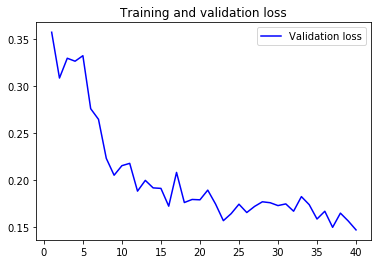

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model reached ~0.15 MAE, which in Celsius corresponds to:

In [20]:
print('MAE: %s Celsius' %(0.15 * std[1]))

MAE: 1.3278748623306929 Celsius


Given that the model does not start overfitting with successive epochs, we may be able to afford adding more GRU layers to the network.

## 3.2. Stacking Recurrent Layers
Let us stack two recurrent layers before the Dense layer.

In [21]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.15, return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.15))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


Let us compile and fit the model.

In [22]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 148s 295ms/step - loss: 216871523644.0279 - val_loss: 0.6556
Epoch 2/40
500/500 [==============================] - 144s 289ms/step - loss: 59155556.0628 - val_loss: 0.6183
Epoch 3/40
500/500 [==============================] - 145s 290ms/step - loss: 217903007.9897 - val_loss: 0.6093
Epoch 4/40
500/500 [==============================] - 145s 290ms/step - loss: 268605231.5965 - val_loss: 0.5553
Epoch 5/40
500/500 [==============================] - 145s 290ms/step - loss: 384457161.0940 - val_loss: 0.5039
Epoch 6/40
500/500 [==============================] - 145s 290ms/step - loss: 8448629.0970 - val_loss: 0.5495
Epoch 7/40
500/500 [==============================] - 145s 290ms/step - loss: 2262279338.9476 - val_loss: 0.4995
Epoch 8/40
500/500 [==============================] - 145s 291ms/step - loss: 1021285177.3249 - val_loss: 0.4812
Epoch 9/40
500/500 [==============================] - 145s 291ms/step - loss: 451783925.5612 - val_los

Let's plot the model performance.

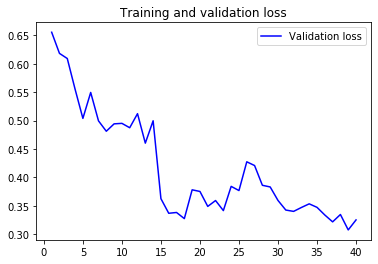

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model reaches ~0.31 MAE.

In [24]:
print('MAE: %s Celsius' %(0.31 * std[1]))

MAE: 2.744274715483432 Celsius


The model with a single LSTM layer did better.

## 3.3. Bidirectional RNNs
This looks to learn sequence orders both forwards and backwards and combine the representations learnt.

In [25]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


We can then compile and fit the model.

In [26]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2977 - val_loss: 0.3048
Epoch 2/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2761 - val_loss: 0.2478
Epoch 3/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2686 - val_loss: 0.3463
Epoch 4/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2632 - val_loss: 0.2646
Epoch 5/40
500/500 [==============================] - 75s 151ms/step - loss: 0.2563 - val_loss: 0.1779
Epoch 6/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2499 - val_loss: 0.2299
Epoch 7/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2443 - val_loss: 0.1580
Epoch 8/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2368 - val_loss: 0.2034
Epoch 9/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2285 - val_loss: 0.1704
Epoch 10/40
500/500 [==============================] - 76s 151ms/step - l

We can the plot the model performance.

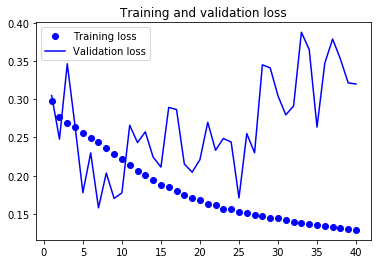

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The model does about as well as having a regular GRU layer. All the predictive power comes from the chronological half of the network.

## 3.4. Combining CNNs and RNNs for Forecasting
We can use 1D covnets to learn local patterns in a sequence. We can afford larger patches with a 1D covnet as it corresponds to less feature vectors than would be the case in a high dimensional space. As with images, each patch has a transformation applied to it before being passed into a pooling layer.

The patches analyzed by the covnet are processed independently and are thus not sensitive to the order of the timestemps beyond the local scale. In contrast, RNNs can learn such long-term dependencies but are computationally expensive.

By combining CNNs and RNNs, we can process longer sequences. We thus choose to reanalyze the data at a higher frequency rate (half-hourly instead of hourly). We need to prepare the data for this higher-resolution.

In [28]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data, lookback=lookback, delay=delay, 
                      min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, 
                    min_index=200001, max_index=300000, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, 
                     min_index=300001, max_index=None, step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

Let us now define a network that combines the CNN and RNN.

In [29]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.15))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


We can now compile and fit the model.

In [30]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 27s 53ms/step - loss: 0.3940 - val_loss: 0.1266
Epoch 2/20
500/500 [==============================] - 26s 53ms/step - loss: 0.3164 - val_loss: 0.1288
Epoch 3/20
500/500 [==============================] - 26s 53ms/step - loss: 0.3022 - val_loss: 0.0570
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.3047 - val_loss: 0.0708
Epoch 5/20
500/500 [==============================] - 29s 58ms/step - loss: 0.3066 - val_loss: 0.0714
Epoch 6/20
500/500 [==============================] - 28s 57ms/step - loss: 0.3092 - val_loss: 0.1612
Epoch 7/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2963 - val_loss: 0.1095
Epoch 8/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2916 - val_loss: 0.1547
Epoch 9/20
500/500 [==============================] - 28s 57ms/step - loss: 0.2880 - val_loss: 0.0918
Epoch 10/20
500/500 [==============================] - 29s 57ms/step - loss: 0.306

We can plot the model performance.

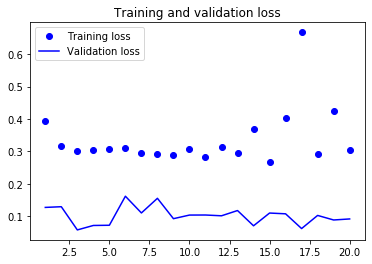

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Even though we are using double the data, the fitting takes half the time and we appear to get more accurate results. We obtain an MAE of ~0.06.

In [32]:
print('MAE: %s Celsius' %(0.06 * std[1]))

MAE: 0.5311499449322772 Celsius
